In [1]:
import cv2 as cv
import numpy as np

cap = cv.VideoCapture(r"C:\kela\tracker\object-tracker\data\input\MAX_0007.mp4")
ret, first_frame = cap.read()

# Resize settings
scale_percent = 10
display_width = int(first_frame.shape[1] * scale_percent / 100)
display_height = int(first_frame.shape[0] * scale_percent / 100)

# Process first frame
first_frame_resized = cv.resize(first_frame, (display_width, display_height))
prev_gray = cv.cvtColor(first_frame_resized, cv.COLOR_BGR2GRAY)

# Create mask for flow visualization
mask = np.zeros_like(first_frame_resized)
mask[..., 1] = 255

motion_history = []
motion_segments = []
while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Resize
    frame = cv.resize(frame, (display_width, display_height))
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Compute optical flow
    flow = cv.calcOpticalFlowFarneback(
        prev_gray, gray, None,
        0.5, 3, 15, 3, 5, 1.2, 0
    )
    
    # Magnitude and angle
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
    
    # Motion statistics
    avg_motion = np.mean(magnitude)
    max_motion = np.max(magnitude)
    motion_history.append(avg_motion)
    
    # Classify motion
    if avg_motion < 1.0:
        motion_type = "STABLE"
        color = (0, 255, 0)
    elif avg_motion < 3:
        motion_type = "MODERATE"
        color = (0, 255, 255)
    elif max_motion > 15.0:
        motion_type = "FAST MOTION"
        color = (0, 0, 255)
    else:
        motion_type = "MOVING"
        color = (0, 165, 255)

    
    
    # Update mask
    mask[..., 0] = angle * 180 / np.pi / 2
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
    
    # Add text overlay
    cv.putText(frame, f"{motion_type}: {avg_motion:.1f}", 
               (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    cv.putText(rgb, f"Max: {max_motion:.1f}", 
               (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    motion_segments.append(avg_motion)
    # Show both
    combined = np.hstack([frame, rgb])
    cv.imshow("Input | Optical Flow", combined)
    
    prev_gray = gray
    
    if cv.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

# Print summary
print(f"\nMotion Analysis:")
print(f"Average motion: {np.mean(motion_history):.2f}")
print(f"Max motion: {np.max(motion_history):.2f}")
print(f"Stable frames: {sum(1 for m in motion_history if m < 1.0)}")
print(f"Total frames: {len(motion_history)}")


Motion Analysis:
Average motion: 0.06
Max motion: 0.10
Stable frames: 64
Total frames: 64


In [60]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
from torchvision import transforms, models
import requests
import numpy as np
import torch
import cv2


processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
patch_size = model.config.patch_size



## Identifie the ID for frames from motion_segments
segments = []
in_segment = False
start_idx = None

for i, moving in enumerate(motion_segments):
    if moving < 1.5 and not in_segment:
        # Start of new STILL segment
        start_idx = i
        in_segment = True
    elif moving >= 1.5 and in_segment:
        # End of STILL segment
        if i - start_idx >= 30:  # Minimum length of 30 frames
            segments.append((start_idx, i))
        in_segment = False
        start_idx = None
print(segments)

        
## load movie
movie = cv2.VideoCapture(r"C:\kela\tracker\object-tracker\data\input\MAX_0010.mp4")
ret, frame = movie.read()
segments_featurs_mat = [] # shape: (n_segments, n_features)
## GET CLS TOKEN FROM SPECIFIC FRAMES
for i,(start, end) in enumerate(segments):
    print(f"Working on segment:{i} Out of {len(segments)} , frames {start} to {end}")
    ## Choose the 5 with lowest motion
    segment_motions = motion_segments[start:end]
    lowest_motion_indices = np.argsort(segment_motions)[:5]

    
    features_list =[]
    for frame_id in lowest_motion_indices:
        ## read frame
        movie.set(cv2.CAP_PROP_POS_FRAMES,start+frame_id)
        ret, frame = movie.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(frame)
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        cls_token = last_hidden_states[:, 0, :]
        features_list.append(cls_token)
    segment_features = torch.cat(features_list, dim=0).mean(dim=0, keepdim=True)
    segments_featurs_mat.append(segment_features)

    
segments_featurs_mat = torch.cat(segments_featurs_mat, dim=0)
print(segments_featurs_mat.shape)  # shape: (n_segments, n_features)



[(0, 34), (158, 325), (425, 1139), (1168, 1207), (1236, 1315), (1357, 1657), (1680, 1951), (1954, 1999), (2104, 2333), (2399, 2616), (2675, 2788), (2876, 3302), (3345, 3578), (3603, 3730), (3753, 3983), (3987, 4120), (4142, 4773), (4813, 5001), (5026, 5165), (5183, 5303), (5383, 5475), (5519, 5558), (5647, 5727), (5763, 5942), (6007, 6063), (6135, 6203), (6231, 6327), (6421, 6508), (6515, 6756), (6858, 6910), (6939, 6991), (7125, 7184)]
Working on segment:0 Out of 32 , frames 0 to 34
Working on segment:1 Out of 32 , frames 158 to 325
Working on segment:2 Out of 32 , frames 425 to 1139
Working on segment:3 Out of 32 , frames 1168 to 1207
Working on segment:4 Out of 32 , frames 1236 to 1315
Working on segment:5 Out of 32 , frames 1357 to 1657
Working on segment:6 Out of 32 , frames 1680 to 1951
Working on segment:7 Out of 32 , frames 1954 to 1999
Working on segment:8 Out of 32 , frames 2104 to 2333
Working on segment:9 Out of 32 , frames 2399 to 2616
Working on segment:10 Out of 32 , fra

In [61]:
## make dot product similarity matrix
segments_featurs_mat = segments_featurs_mat / segments_featurs_mat.norm(dim=1, keepdim=True)
COS = segments_featurs_mat @ segments_featurs_mat.T
print(COS.shape)  # shape: (n_segments, n_segments)

torch.Size([32, 32])


In [66]:
print("minimum similarity:", COS.min().item())

minimum similarity: 0.12826134264469147


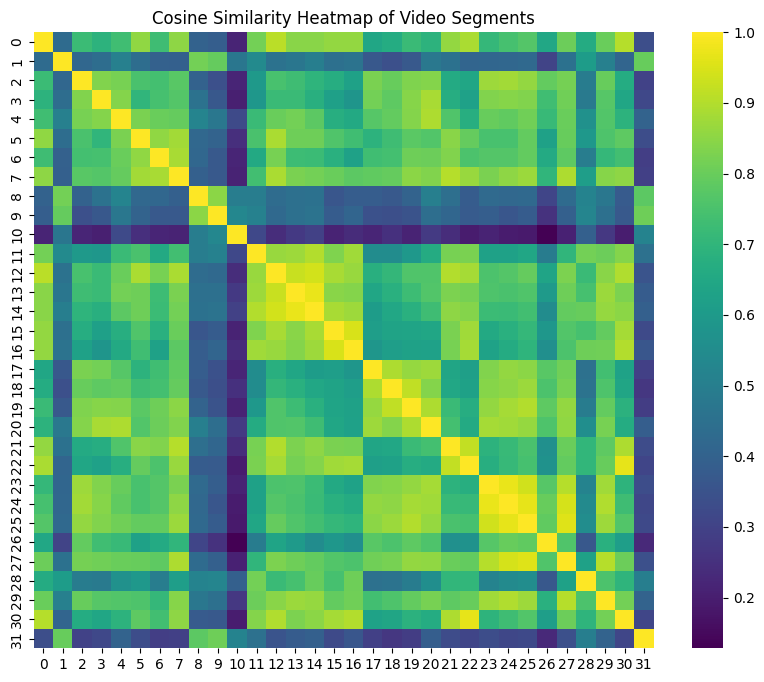

In [62]:
## make heatmap for COS
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(COS.numpy(), cmap='viridis')
plt.title('Cosine Similarity Heatmap of Video Segments')
plt.show() 


In [63]:
segments

[(0, 34),
 (158, 325),
 (425, 1139),
 (1168, 1207),
 (1236, 1315),
 (1357, 1657),
 (1680, 1951),
 (1954, 1999),
 (2104, 2333),
 (2399, 2616),
 (2675, 2788),
 (2876, 3302),
 (3345, 3578),
 (3603, 3730),
 (3753, 3983),
 (3987, 4120),
 (4142, 4773),
 (4813, 5001),
 (5026, 5165),
 (5183, 5303),
 (5383, 5475),
 (5519, 5558),
 (5647, 5727),
 (5763, 5942),
 (6007, 6063),
 (6135, 6203),
 (6231, 6327),
 (6421, 6508),
 (6515, 6756),
 (6858, 6910),
 (6939, 6991),
 (7125, 7184)]